Backpropagate through a neuron. In complex nonlinear neural networks, we apply the activation function to the dot product of the weights and the input to learn complex patterns in data.
In this example, we're doing the tanh function

In [32]:
%run micrograd.ipynb

We want to implement tanh, so let's add a new method to the Value object.

$\tanh x$ = $\frac{\sinh x}{\cosh x}$ = $\frac{e^{2x} - 1}{e^{2x} + 1}$

In [33]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
            
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
        
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        return Value(t, (self,), 'tanh')

In [34]:
# inputs x1, x2:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2:
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881373789402, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

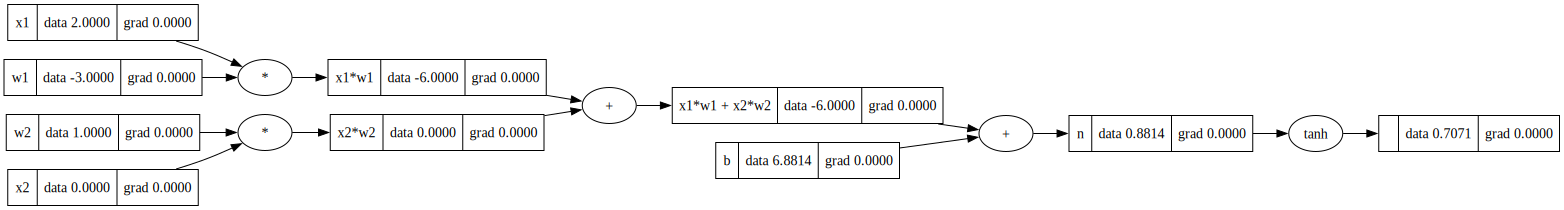

In [35]:
draw_dot(o)

Backprop time (fill out the gradients):

In [36]:
o.grad = 1.0

\begin{aligned}
o &= \tanh(n) \\
\frac{d o}{d n} &= 1 - \tanh^2(n) = 1 - o^2
\end{aligned}


In [37]:
n.grad = 1 - o.data ** 2

# the gradient flows through plus node:

x1w1x2w2.grad = b.grad = n.grad

x1w1.grad = x2w2.grad = x1w1x2w2.grad

# for times node, the local derivative is the value of the other node:

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

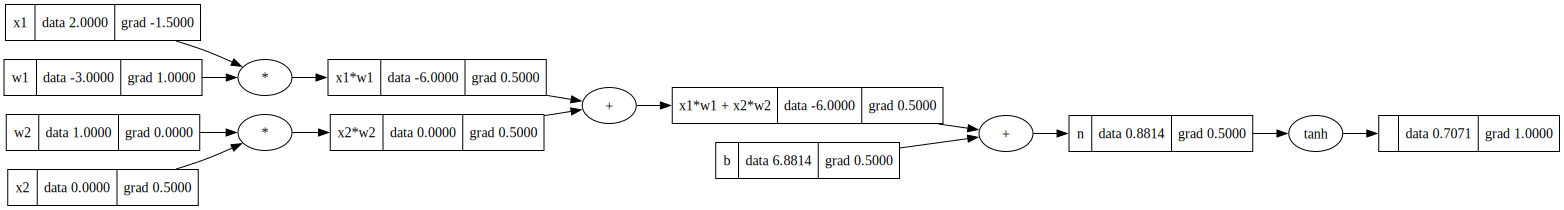

In [38]:
draw_dot(o)

In [39]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None # empty function for leaf nodes
        self._prev = set(_children)
        self._op = _op
        self.label = label
            
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        # we need to take out's grad and propagate it to self's and other's grads
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # the local derivation of (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
            
        out._backward = _backward
        return out

In [40]:
# inputs x1, x2:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2:
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881373789402, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

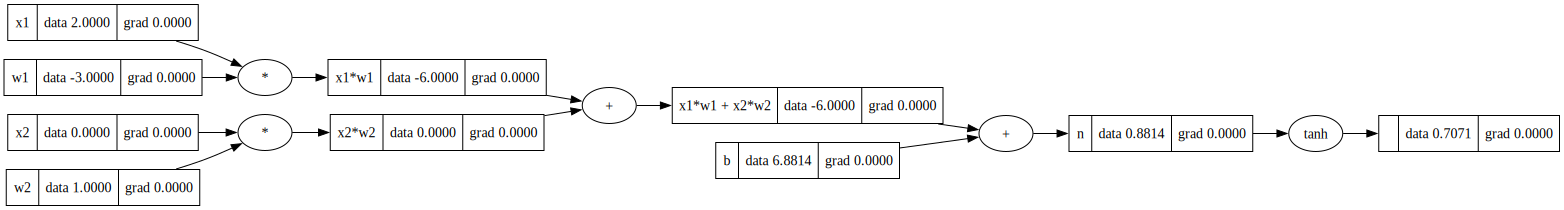

In [41]:
draw_dot(o)

In [42]:
o.grad = 1.0

In [43]:
o._backward()

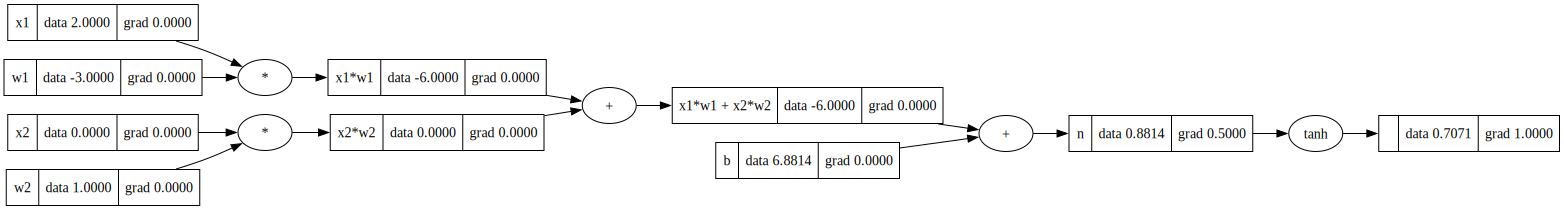

In [44]:
draw_dot(o) # Now n's grad is 0.5
# instead of doing it all manually, we're calling the backward() function

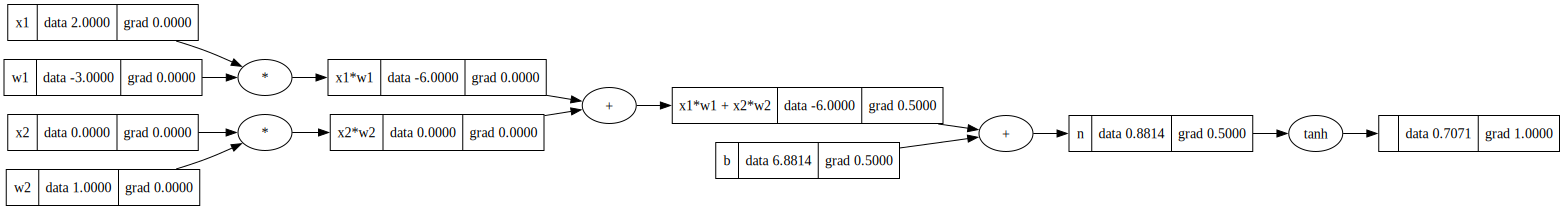

In [45]:
n._backward()
draw_dot(o) # plus node, gradient flows

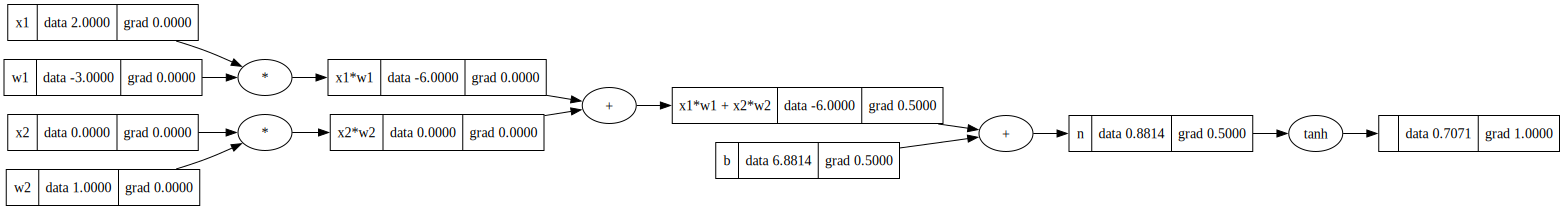

In [46]:
b._backward()
# nothing happens because it's a leaf node, and by default, it's None
draw_dot(o)

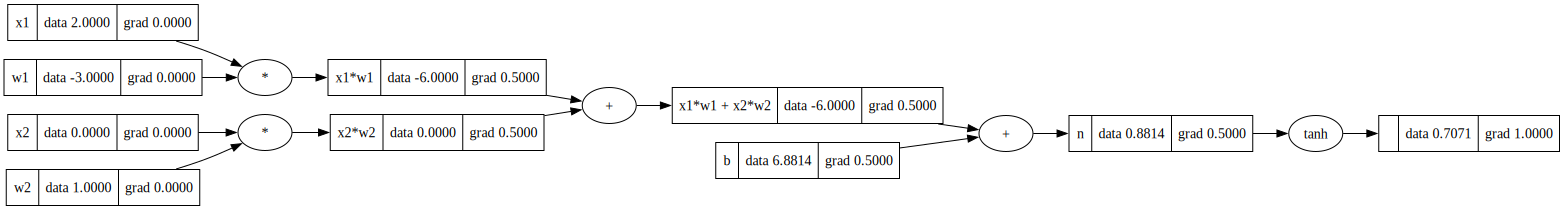

In [47]:
x1w1x2w2._backward()
draw_dot(o)

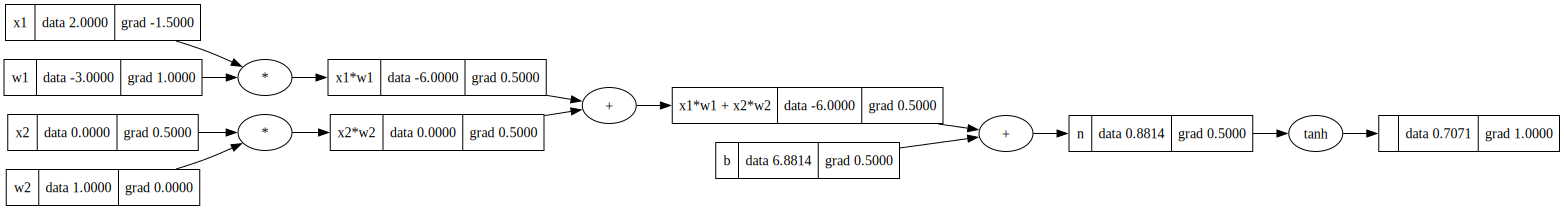

In [48]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

#### Topological sort
Processes all children before processing the node itself. 

In [49]:
# inputs x1, x2:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2:
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881373789402, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

In [50]:
o.grad = 1.0

topo = []
visited = set()
def build(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build(child)
        topo.append(v)
build(o)

for node in reversed(topo):
    node._backward()

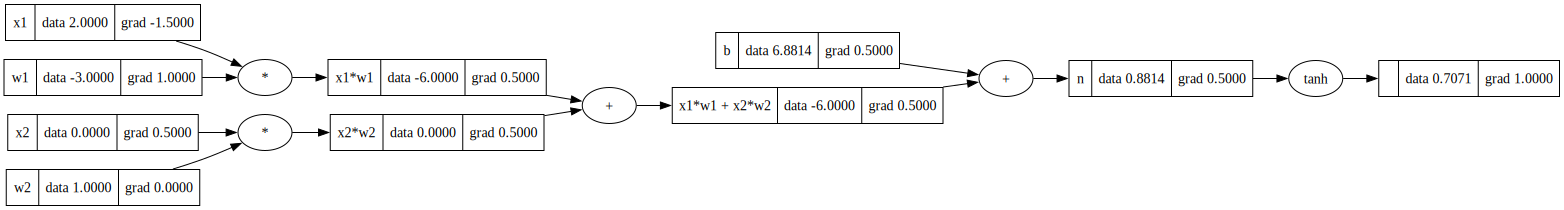

In [51]:
draw_dot(o) # using topological sort to backpropagate (we process propagate from the root node to the children)

#### PyTorch comparison
In micrograd, we only have scalar values, but in PyTorch, there are tensors - n-dimensional arrays of scalars:

In [52]:
import torch

In [55]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 0.0
